# 3D Voxel VAE 90 Results


In [1]:
import os
import math
import random
import pickle
import numpy as np
import pandas as pd
from pathlib import Path
from collections import Counter
import matplotlib
matplotlib.use('pdf')
import matplotlib.pyplot as plt
from matplotlib.pyplot import imshow
from IPython.display import display, HTML
from mpl_toolkits.mplot3d import Axes3D

import torch
from torch import nn, optim
import torch.nn.functional as F
from torch.nn import functional as F
from torch.utils.data import DataLoader
import torchvision
import torchvision.transforms as transforms
import torch.backends.cudnn as cudnn
from torch.optim.lr_scheduler import StepLR

import kaolin as kal
from kaolin.datasets import ModelNet, ModelNetVoxels

# from models import *
from dataset.trans_model_net_voxels import TransformedModelNetVoxels


%reload_ext autoreload
%autoreload 2
%matplotlib inline

## Training on augmented data is harder

# ? Adding error bars?
Can try list of different model sizes, get graph showing mse worse for all

#### Training Progress
* WIth augmentation has strictly higher loss

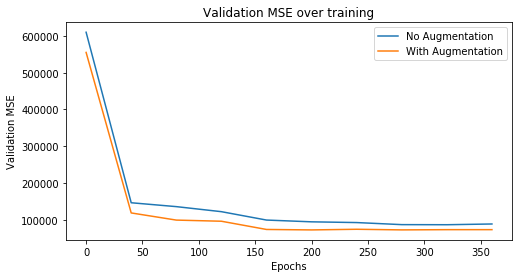

In [4]:
save_path_aug = './results/test1_aug_noopt/avae_modelnet_1class_90aug_noopt_l8'
save_path_noaug = './results/test1_aug_noopt/avae_modelnet_1class_noaug_noopt_l8'
results = pd.DataFrame()

for i in range(10):
    checkpoint_noaug = torch.load(save_path_aug + '/' + str(i) + '_ckpt.pth')
    checkpoint_90aug = torch.load(save_path_noaug + '/' + str(i) + '_ckpt.pth')
    results = results.append({'epoch': checkpoint_noaug["epoch"],
                             'noaug_mse': checkpoint_noaug["val_mse"],
                             '90aug_mse': checkpoint_90aug["val_mse"]},
                             ignore_index = True)
    
fig = plt.figure(figsize=(8, 4))
plt.plot(results['epoch'], results['noaug_mse'], label='No Augmentation')
plt.plot(results['epoch'], results['90aug_mse'], label='With Augmentation')
plt.title("Validation MSE over training")
plt.xlabel("Epochs")
plt.ylabel("Validation MSE")
plt.legend()
plt.show()

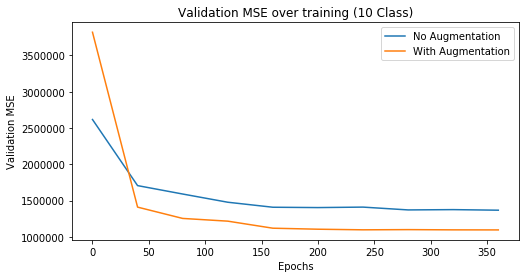

In [7]:
save_path_aug = './results/test1_aug_noopt/avae_modelnet_10class_90aug_noopt_l8'
save_path_noaug = './results/test1_aug_noopt/avae_modelnet_10class_noaug_noopt_l8'
results = pd.DataFrame()

for i in range(10):
    checkpoint_noaug = torch.load(save_path_aug + '/' + str(i) + '_ckpt.pth')
    checkpoint_90aug = torch.load(save_path_noaug + '/' + str(i) + '_ckpt.pth')
    results = results.append({'epoch': checkpoint_noaug["epoch"],
                             'noaug_mse': checkpoint_noaug["val_mse"],
                             '90aug_mse': checkpoint_90aug["val_mse"]},
                             ignore_index = True)
    
fig = plt.figure(figsize=(8, 4))
plt.plot(results['epoch'], results['noaug_mse'], label='No Augmentation')
plt.plot(results['epoch'], results['90aug_mse'], label='With Augmentation')
plt.title("Validation MSE over training (10 Class)")
plt.xlabel("Epochs")
plt.ylabel("Validation MSE")
plt.legend()
plt.show()

#### MSE on aug and not aug for different latent sizes, and for 1 vs. 10 classes
* Is no aug consistently better?

In [63]:
save_path = './results/avae_modelnet_1class_90aug_noopt_l8'
checkpoint = torch.load(save_path + '/best_ckpt.pth')
print(f'MSE: {checkpoint["val_mse"]} Params: {checkpoint["num_params"]}')

MSE: 86151.7578125 Params: 215665


In [64]:
save_path = './results/avae_modelnet_1class_noaug_noopt_l8'
checkpoint = torch.load(save_path + '/best_ckpt.pth')
print(f'MSE: {checkpoint["val_mse"]} Params: {checkpoint["num_params"]}')

MSE: 74384.78125 Params: 215665


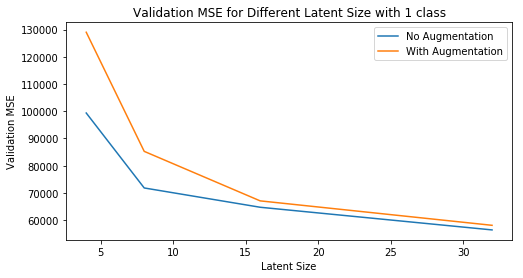

In [3]:
save_path_90aug = './results/test1_aug_noopt/avae_modelnet_1class_90aug_noopt_l'
save_path_noaug = './results/test1_aug_noopt/avae_modelnet_1class_noaug_noopt_l'
results = pd.DataFrame()

for i in [4, 8, 16, 32]:
    checkpoint_90aug = torch.load(save_path_90aug + str(i) + '/best_ckpt.pth')
    checkpoint_noaug = torch.load(save_path_noaug + str(i) + '/best_ckpt.pth')
    results = results.append({'latent_size': i,
                             'noaug_mse': checkpoint_noaug["val_mse"],
                             '90aug_mse': checkpoint_90aug["val_mse"]},
                             ignore_index = True)
    
fig = plt.figure(figsize=(8, 4))
plt.plot(results['latent_size'], results['noaug_mse'], label='No Augmentation')
plt.plot(results['latent_size'], results['90aug_mse'], label='With Augmentation')
plt.title("Validation MSE for Different Latent Size with 1 class")
plt.xlabel("Latent Size")
plt.ylabel("Validation MSE")
plt.legend()
plt.show()

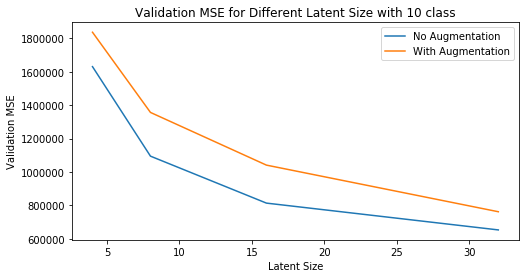

In [6]:
save_path_90aug = './results/test1_aug_noopt/avae_modelnet_10class_90aug_noopt_l'
save_path_noaug = './results/test1_aug_noopt/avae_modelnet_10class_noaug_noopt_l'
results = pd.DataFrame()

for i in [4, 8, 16, 32]:
    checkpoint_noaug = torch.load(save_path_noaug + str(i) + '/best_ckpt.pth')
    checkpoint_90aug = torch.load(save_path_90aug + str(i) + '/best_ckpt.pth')
    results = results.append({'latent_size': i,
                             'noaug_mse': checkpoint_noaug["val_mse"],
                             '90aug_mse': checkpoint_90aug["val_mse"]},
                             ignore_index = True)
    
fig = plt.figure(figsize=(8, 4))
plt.plot(results['latent_size'], results['noaug_mse'], label='No Augmentation')
plt.plot(results['latent_size'], results['90aug_mse'], label='With Augmentation')
plt.title("Validation MSE for Different Latent Size with 10 class")
plt.xlabel("Latent Size")
plt.ylabel("Validation MSE")
plt.legend()
fig.savefig('./plots/mse_90rot_10c.pdf')
plt.show()


## All 90 Optimization vs. No Optimization on 90 Degree Rotations


In [1]:
save_path_90aug_noopt = './results/test1_aug_noopt/avae_modelnet_1class_90aug_noopt_l'
save_path_90aug_90opt = './results/test2_90_aug_opt/avae_modelnet_1class_90aug_all90_l'
results = pd.DataFrame()

for i in [4, 8, 16, 32]:
    checkpoint_noopt = torch.load(save_path_90aug_noopt + str(i) + '/best_ckpt.pth')
    checkpoint_opt = torch.load(save_path_90aug_90opt + str(i) + '/best_ckpt.pth')
    results = results.append({'latent_size': i,
                             'mse_noopt': checkpoint_noopt["val_mse"],
                             'mse_opt': checkpoint_opt["val_mse"]},
                             ignore_index = True)
    
fig = plt.figure(figsize=(8, 4))
plt.plot(results['latent_size'], results['mse_noopt'], label='No Optimization')
plt.plot(results['latent_size'], results['mse_opt'], label='90 Optimization')
plt.title("Validation MSE for Different Latent Size, opt. vs. no opt with 1 class")
plt.xlabel("Latent Size")
plt.ylabel("Validation MSE")
plt.legend()
plt.show()

NameError: name 'pd' is not defined

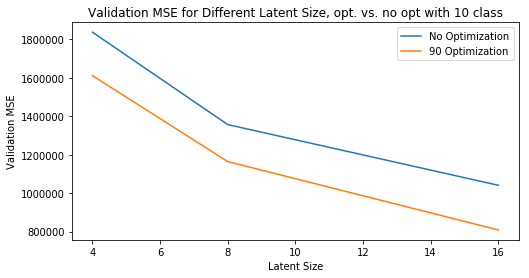

In [7]:
save_path_90aug_noopt = './results/test1_aug_noopt/avae_modelnet_10class_90aug_noopt_l'
save_path_90aug_90opt = './results/test2_90_aug_opt/avae_modelnet_10class_90aug_all90_l'
results = pd.DataFrame()

for i in [4, 8, 16]:
    checkpoint_noopt = torch.load(save_path_90aug_noopt + str(i) + '/best_ckpt.pth')
    checkpoint_opt = torch.load(save_path_90aug_90opt + str(i) + '/best_ckpt.pth')
    results = results.append({'latent_size': i,
                             'mse_noopt': checkpoint_noopt["val_mse"],
                             'mse_opt': checkpoint_opt["val_mse"]},
                             ignore_index = True)
    
fig = plt.figure(figsize=(8, 4))
plt.plot(results['latent_size'], results['mse_noopt'], label='No Optimization')
plt.plot(results['latent_size'], results['mse_opt'], label='90 Optimization')
plt.title("Validation MSE for Different Latent Size, opt. vs. no opt with 10 class")
plt.xlabel("Latent Size")
plt.ylabel("Validation MSE")
plt.legend()
fig.savefig('./plots/mse_90rot_opt_vsno_10c.pdf')

plt.show()

## Distribution of rotations with and without optimization

In [13]:
def rotationMatrixToEulerAngles(R) :
    sy = math.sqrt(R[0,0] * R[0,0] +  R[1,0] * R[1,0])
    singular = sy < 1e-6
    if  not singular:
        x = math.atan2(R[2,1] , R[2,2])
        y = math.atan2(-R[2,0], sy)
        z = math.atan2(R[1,0], R[0,0])
    else :
        x = math.atan2(-R[1,2], R[1,1])
        y = math.atan2(-R[2,0], sy)
        z = 0
    return np.round(np.array([x, y, z]), 4)

def eulerAnglesToRotationMatrix(theta) :
    R_x = np.array([[1,         0,                  0                   ],
                    [0,         math.cos(theta[0]), -math.sin(theta[0]) ],
                    [0,         math.sin(theta[0]), math.cos(theta[0])  ]
                   ])
    R_y = np.array([[math.cos(theta[1]),    0,      math.sin(theta[1])  ],
                    [0,                     1,      0                   ],
                    [-math.sin(theta[1]),   0,      math.cos(theta[1])  ]
                   ])
    R_z = np.array([[math.cos(theta[2]),    -math.sin(theta[2]),    0],
                    [math.sin(theta[2]),    math.cos(theta[2]),     0],
                    [0,                     0,                      1]])
    R = np.dot(R_z, np.dot( R_y, R_x ))
    return R

def show_rotations(x, rot_mat_list):
    nrows, ncols = int(len(rot_mat_list)/2), 2
    fig = plt.figure(figsize=(10, nrows*4))
    for idx in range(0, nrows*ncols, 1):
        rotated_x = affine_transform(x, rot_mat_list[idx].to(device))    
        rotated_x = rotated_x > .5
        ax = fig.add_subplot(nrows, ncols, idx + 1, projection='3d')
        ax.voxels(rotated_x.squeeze(), facecolors='blue', edgecolor='k')

#### Mutiply the initial (data augmentation) rotation with optimized one to get final orientation fed into VAE
* Clearly something is being learned, some orientations are much more frequent than others.
* Quite different from the uniform distribution we'd expect if encoder was equally good at every rotation

But is this really disentangling rotation?

In [5]:
save_path_90aug_noopt = './results/test1_aug_noopt/avae_modelnet_1class_90aug_noopt_l4'
save_path_90aug_90opt = './results/test2_90_aug_opt/avae_modelnet_1class_90aug_all90_l4'
checkpoint_noopt = torch.load(save_path_90aug_noopt + '/best_ckpt.pth')
checkpoint_90opt = torch.load(save_path_90aug_90opt + '/best_ckpt.pth')
print(checkpoint_90opt.keys())

data_ap = checkpoint_90opt['data_ap_list']
model_ap = checkpoint_90opt['model_ap_list']

rotation_mats = []
rotation_angles = []
for i in range(data_ap.shape[0]):
    rotation_mats.append(np.matmul(data_ap[i, :,:3], model_ap[i, :,:3]))

rotation_angles = [rotationMatrixToEulerAngles(x) for x in rotation_mats]
str_angles = Counter([''.join(str(e)) for e in rotation_angles])
str_angles = {k: v for k, v in sorted(str_angles.items(), key=lambda item: item[1], reverse=True)}
str_angles

dict_keys(['model', 'val_loss', 'val_mse', 'epoch', 'data_ap_list', 'model_ap_list', 'num_params'])


{'[ 3.1416 -0.     -1.5708]': 14,
 '[ 0. -0.  0.]': 14,
 '[ 3.1416 -0.      3.1416]': 11,
 '[ 3.1416 -0.      1.5708]': 9,
 '[ 0.     -0.     -1.5708]': 8,
 '[ 0.     -0.      1.5708]': 8,
 '[ 0.     -0.      3.1416]': 7,
 '[ 3.1416 -0.      0.    ]': 7,
 '[-0.      1.5708  0.    ]': 2,
 '[-1.5708  1.5708  0.    ]': 2,
 '[ 1.5708 -0.      1.5708]': 1,
 '[-0.     -1.5708  0.    ]': 1,
 '[-3.1416 -1.5708  0.    ]': 1,
 '[1.5708 1.5708 0.    ]': 1}

#### Look at examples of this
* How were they actually encoded in practice?
* Valset will have same order as dataloader, because shuffle=False

In [10]:
def affine_transform(x, affine_params, padding_mode='zeros'):
    grid = F.affine_grid(affine_params, x.size(), align_corners=False).cuda()
    x = F.grid_sample(x, grid, padding_mode=padding_mode, align_corners=False)
    return x


def plot_transformed_voxels(batch, affine_params_data, affine_params_model, nsamples=4, voxel_threshold=.5,
                           save_path=None):
    x = batch['data']['32'].to(device)[:nsamples, :, :, :].unsqueeze(1)
    augmented_x = affine_transform(x, affine_params_data[:nsamples, :, :], padding_mode='zeros')
    transformed_x = affine_transform(augmented_x, affine_params_model[:nsamples, :, :], padding_mode='zeros')
    
    augmented_x = augmented_x > voxel_threshold
    transformed_x = transformed_x > voxel_threshold
    augmented_x, transformed_x = augmented_x.squeeze(), transformed_x.squeeze()
    labels = batch['attributes']['category'][:nsamples]
    
    nrows, ncols = nsamples, 2
    fig = plt.figure(figsize=(8, 2.5*nsamples))
    for idx in range(nrows):
        label = labels[idx]
        ax = fig.add_subplot(nrows, ncols, 2*idx + 1, projection='3d')
        ax.voxels(augmented_x[idx, :, :, :], facecolors='blue', edgecolor='k')
        if idx == 0: ax.set_title('Input', fontsize='large')
        ax.axis('off')
        
        ax = fig.add_subplot(nrows, ncols, 2*idx + 2, projection='3d')
        ax.voxels(transformed_x[idx, :, :, :], facecolors='blue', edgecolor='k')
        ax.axis('off')
        if idx == 0: ax.set_title('Transformed', fontsize='large')
    fig.tight_layout() 
    if save_path is not None:
        fig.savefig(save_path)
        

In [11]:
modelnet_path = './data/ModelNet10'
categories = ['dresser']
device = 'cuda:0'
bs = 7

trainset = TransformedModelNetVoxels(modelnet_path, transform_type='random_90_rot', categories=categories, 
                                     resolutions=[32], split='train', device=device)
valset = TransformedModelNetVoxels(modelnet_path, transform_type='none', categories=categories, 
                                   resolutions=[32], split='test', device=device)
train_loader = DataLoader(trainset, batch_size=bs)
val_loader = DataLoader(valset, batch_size=2*bs)
val_batch = next(iter(val_loader))

converting to voxels to resolution 32: 100%|██████████| 86/86 [00:00<00:00, 30452.52it/s]


{'[ 3.1416 -0.     -1.5708]': 14,
 '[ 0. -0.  0.]': 14,
 '[ 3.1416 -0.      3.1416]': 11,
 '[ 3.1416 -0.      1.5708]': 9,
 '[ 0.     -0.     -1.5708]': 8,
 '[ 0.     -0.      1.5708]': 8,
 '[ 0.     -0.      3.1416]': 7,
 '[ 3.1416 -0.      0.    ]': 7,
 '[-0.      1.5708  0.    ]': 2,
 '[-1.5708  1.5708  0.    ]': 2,
 '[ 1.5708 -0.      1.5708]': 1,
 '[-0.     -1.5708  0.    ]': 1,
 '[-3.1416 -1.5708  0.    ]': 1,
 '[1.5708 1.5708 0.    ]': 1}

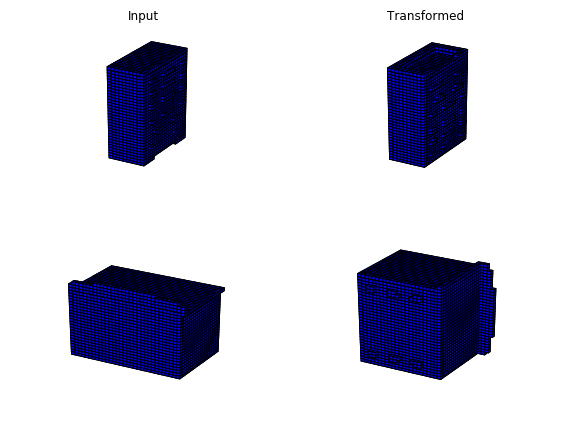

In [77]:
save_path_90aug_noopt = './results/test1_aug_noopt/avae_modelnet_1class_90aug_noopt_l4'
save_path_90aug_90opt = './results/test2_90_aug_opt/avae_modelnet_1class_90aug_all90_l4'
checkpoint_noopt = torch.load(save_path_90aug_noopt + '/best_ckpt.pth')
checkpoint_90opt = torch.load(save_path_90aug_90opt + '/best_ckpt.pth')

plot_transformed_voxels(val_batch, 
                      affine_params_data=torch.FloatTensor(checkpoint_90opt['data_ap_list']), 
                      affine_params_model=torch.FloatTensor(checkpoint_90opt['model_ap_list']), 
                      nsamples=2)

data_ap = checkpoint_90opt['data_ap_list']
model_ap = checkpoint_90opt['model_ap_list']
rotation_mats = []
rotation_angles = []
for i in range(data_ap.shape[0]):
    rotation_mats.append(np.matmul(data_ap[i, :,:3], model_ap[i, :,:3]))

rotation_angles = [rotationMatrixToEulerAngles(x) for x in rotation_mats]
str_angles = Counter([''.join(str(e)) for e in rotation_angles])
str_angles = {k: v for k, v in sorted(str_angles.items(), key=lambda item: item[1], reverse=True)}
str_angles

converting to voxels to resolution 32: 100%|██████████| 100/100 [00:00<00:00, 33578.61it/s]


{'[-3.1416 -1.5708  0.    ]': 13,
 '[-1.5708 -0.      3.1416]': 11,
 '[ 1.5708 -0.      0.    ]': 10,
 '[-1.5708 -1.5708  0.    ]': 10,
 '[ 1.5708 -0.      3.1416]': 9,
 '[ 1.5708 -0.     -1.5708]': 8,
 '[-1.5708  1.5708  0.    ]': 8,
 '[ 0.     -0.     -1.5708]': 4,
 '[1.5708 1.5708 0.    ]': 4,
 '[-3.1416  1.5708  0.    ]': 4,
 '[-0.      1.5708  0.    ]': 3,
 '[ 1.5708 -0.      1.5708]': 3,
 '[-1.5708 -0.     -1.5708]': 2,
 '[-1.5708 -0.      1.5708]': 2,
 '[ 0. -0.  0.]': 2,
 '[-1.5708 -0.      0.    ]': 2,
 '[ 0.     -0.      1.5708]': 2,
 '[-0.     -1.5708  0.    ]': 1,
 '[ 0.     -0.      3.1416]': 1,
 '[ 3.1416 -0.      0.    ]': 1}

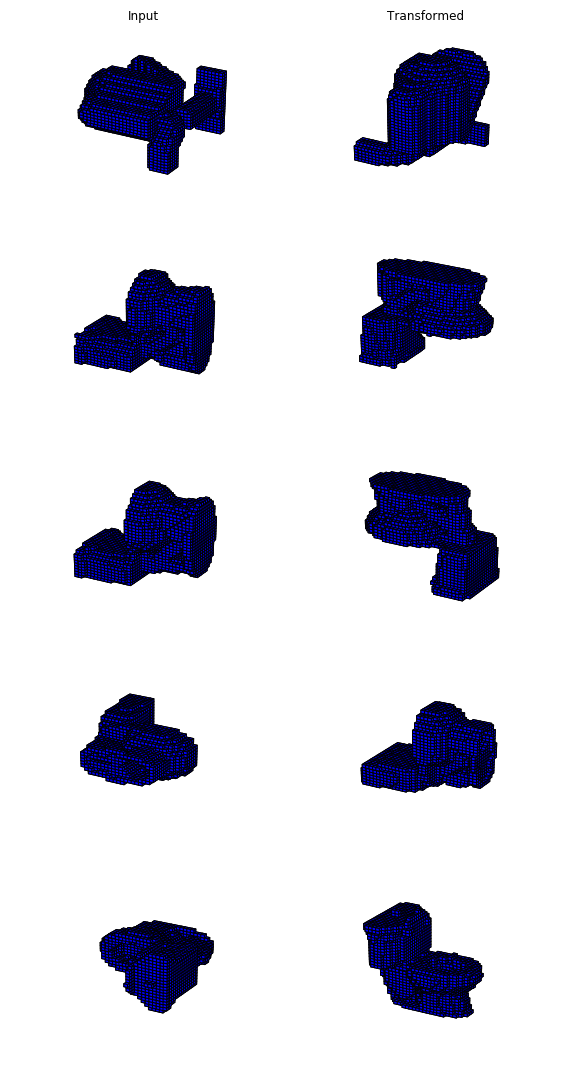

In [78]:
modelnet_path = './data/ModelNet10'
device = 'cuda:0'
bs = 13

categories = ['toilet']
save_path_90aug_90opt = './results/test2_90_aug_opt/avae_modelnet_'+categories[0]+'_90aug_all90_l8'
checkpoint_90opt = torch.load(save_path_90aug_90opt + '/best_ckpt.pth')

trainset = TransformedModelNetVoxels(modelnet_path, transform_type='random_90_rot', categories=categories, 
                                     resolutions=[32], split='train', device=device)
valset = TransformedModelNetVoxels(modelnet_path, transform_type='none', categories=categories, 
                                   resolutions=[32], split='test', device=device)
train_loader = DataLoader(trainset, batch_size=bs)
val_loader = DataLoader(valset, batch_size=2*bs)
val_batch = next(iter(val_loader))

plot_transformed_voxels(val_batch, 
                      affine_params_data=torch.FloatTensor(checkpoint_90opt['data_ap_list']), 
                      affine_params_model=torch.FloatTensor(checkpoint_90opt['model_ap_list']), 
                      nsamples=5,
                      save_path='./plots/'+str(categories[0])+'_rotated.pdf')

data_ap = checkpoint_90opt['data_ap_list']
model_ap = checkpoint_90opt['model_ap_list']
rotation_mats = []
rotation_angles = []
for i in range(data_ap.shape[0]):
    rotation_mats.append(np.matmul(data_ap[i, :,:3], model_ap[i, :,:3]))

rotation_angles = [rotationMatrixToEulerAngles(x) for x in rotation_mats]
str_angles = Counter([''.join(str(e)) for e in rotation_angles])
str_angles = {k: v for k, v in sorted(str_angles.items(), key=lambda item: item[1], reverse=True)}
str_angles

converting to voxels to resolution 32: 100%|██████████| 100/100 [00:00<00:00, 34127.78it/s]


{'[ 1.5708 -0.      0.    ]': 15,
 '[-1.5708 -0.      3.1416]': 12,
 '[-1.5708 -0.      0.    ]': 10,
 '[-1.5708  1.5708  0.    ]': 9,
 '[ 1.5708 -1.5708  0.    ]': 9,
 '[-1.5708 -1.5708  0.    ]': 9,
 '[ 1.5708 -0.      3.1416]': 7,
 '[1.5708 1.5708 0.    ]': 7,
 '[ 3.1416 -0.      1.5708]': 6,
 '[ 0.     -0.      1.5708]': 4,
 '[ 3.1416 -0.     -1.5708]': 3,
 '[-3.1416  1.5708  0.    ]': 3,
 '[ 0.     -0.     -1.5708]': 2,
 '[ 1.5708 -0.      1.5708]': 1,
 '[ 1.5708 -0.     -1.5708]': 1,
 '[-1.5708 -0.      1.5708]': 1,
 '[-1.5708 -0.     -1.5708]': 1}

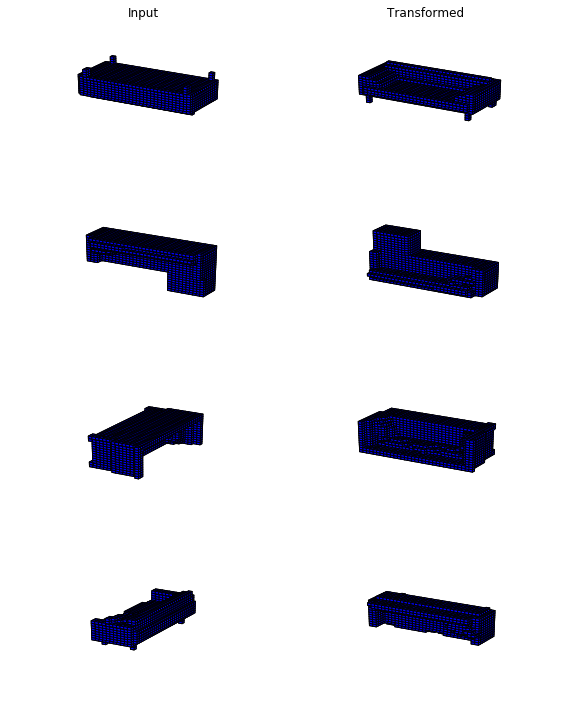

In [14]:
categories = ['sofa']
save_path_90aug_90opt = './results/test2_90_aug_opt/avae_modelnet_'+categories[0]+'_90aug_all90_l8'
checkpoint_90opt = torch.load(save_path_90aug_90opt + '/best_ckpt.pth')

trainset = TransformedModelNetVoxels(modelnet_path, transform_type='random_90_rot', categories=categories, 
                                     resolutions=[32], split='train', device=device)
valset = TransformedModelNetVoxels(modelnet_path, transform_type='none', categories=categories, 
                                   resolutions=[32], split='test', device=device)
train_loader = DataLoader(trainset, batch_size=bs)
val_loader = DataLoader(valset, batch_size=2*bs)
val_batch = next(iter(val_loader))

plot_transformed_voxels(val_batch, 
                      affine_params_data=torch.FloatTensor(checkpoint_90opt['data_ap_list']), 
                      affine_params_model=torch.FloatTensor(checkpoint_90opt['model_ap_list']), 
                      nsamples=4,
                      save_path='./plots/'+str(categories[0])+'_rotated.pdf')

data_ap = checkpoint_90opt['data_ap_list']
model_ap = checkpoint_90opt['model_ap_list']
rotation_mats = []
rotation_angles = []
for i in range(data_ap.shape[0]):
    rotation_mats.append(np.matmul(data_ap[i, :,:3], model_ap[i, :,:3]))

rotation_angles = [rotationMatrixToEulerAngles(x) for x in rotation_mats]
str_angles = Counter([''.join(str(e)) for e in rotation_angles])
str_angles = {k: v for k, v in sorted(str_angles.items(), key=lambda item: item[1], reverse=True)}
str_angles

converting to voxels to resolution 32: 100%|██████████| 100/100 [00:00<00:00, 31443.92it/s]


{'[-0.      1.5708  0.    ]': 10,
 '[-1.5708 -0.      0.    ]': 10,
 '[-1.5708 -0.      3.1416]': 9,
 '[-3.1416  1.5708  0.    ]': 9,
 '[-1.5708 -0.      1.5708]': 9,
 '[-1.5708  1.5708  0.    ]': 8,
 '[1.5708 1.5708 0.    ]': 8,
 '[ 1.5708 -0.      0.    ]': 7,
 '[-1.5708 -1.5708  0.    ]': 6,
 '[-1.5708 -0.     -1.5708]': 5,
 '[ 1.5708 -1.5708  0.    ]': 4,
 '[ 1.5708 -0.      3.1416]': 4,
 '[ 1.5708 -0.      1.5708]': 2,
 '[-0.     -1.5708  0.    ]': 2,
 '[-3.1416 -1.5708  0.    ]': 2,
 '[ 0.     -0.      3.1416]': 2,
 '[ 3.1416 -0.     -1.5708]': 1,
 '[ 0. -0.  0.]': 1,
 '[ 0.     -0.     -1.5708]': 1}

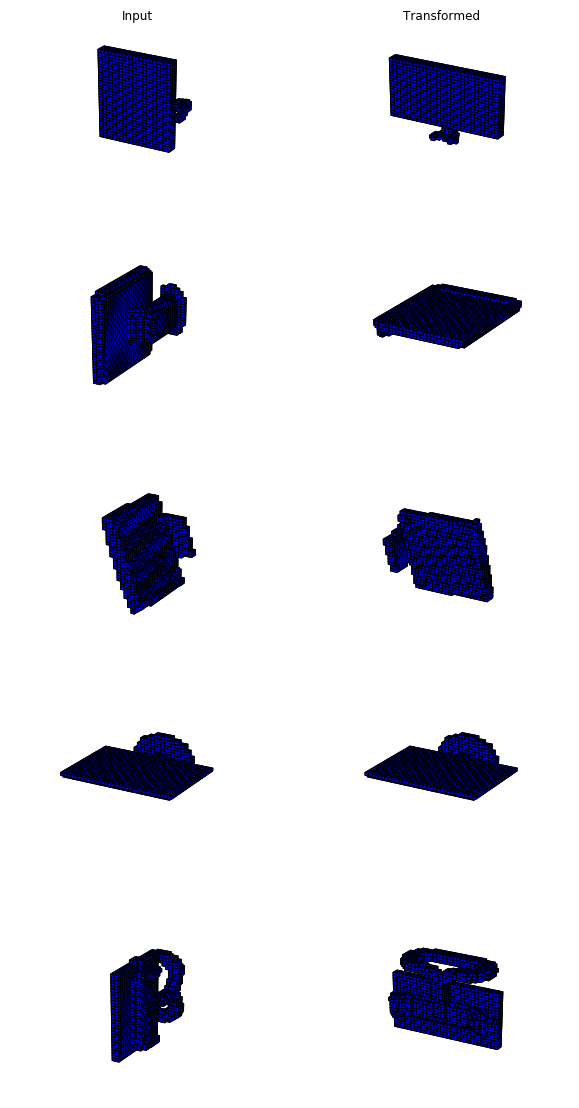

In [68]:
categories = ['monitor']
save_path_90aug_90opt = './results/test2_90_aug_opt/avae_modelnet_'+categories[0]+'_90aug_all90_l8'
checkpoint_90opt = torch.load(save_path_90aug_90opt + '/best_ckpt.pth')

trainset = TransformedModelNetVoxels(modelnet_path, transform_type='random_90_rot', categories=categories, 
                                     resolutions=[32], split='train', device=device)
valset = TransformedModelNetVoxels(modelnet_path, transform_type='none', categories=categories, 
                                   resolutions=[32], split='test', device=device)
train_loader = DataLoader(trainset, batch_size=bs)
val_loader = DataLoader(valset, batch_size=2*bs)
val_batch = next(iter(val_loader))

plot_transformed_voxels(val_batch, 
                      affine_params_data=torch.FloatTensor(checkpoint_90opt['data_ap_list']), 
                      affine_params_model=torch.FloatTensor(checkpoint_90opt['model_ap_list']), 
                      nsamples=5,
                      save_path='./plots/'+str(categories[0])+'_rotated.pdf')

data_ap = checkpoint_90opt['data_ap_list']
model_ap = checkpoint_90opt['model_ap_list']
rotation_mats = []
rotation_angles = []
for i in range(data_ap.shape[0]):
    rotation_mats.append(np.matmul(data_ap[i, :,:3], model_ap[i, :,:3]))

rotation_angles = [rotationMatrixToEulerAngles(x) for x in rotation_mats]
str_angles = Counter([''.join(str(e)) for e in rotation_angles])
str_angles = {k: v for k, v in sorted(str_angles.items(), key=lambda item: item[1], reverse=True)}
str_angles

converting to voxels to resolution 32: 100%|██████████| 100/100 [00:00<00:00, 28046.17it/s]


{'[ 1.5708 -0.      1.5708]': 16,
 '[-0.      1.5708  0.    ]': 15,
 '[-3.1416 -1.5708  0.    ]': 11,
 '[ 1.5708 -0.     -1.5708]': 10,
 '[-1.5708 -0.     -1.5708]': 10,
 '[-3.1416  1.5708  0.    ]': 8,
 '[-1.5708 -0.      1.5708]': 5,
 '[ 1.5708 -0.      0.    ]': 5,
 '[-0.     -1.5708  0.    ]': 4,
 '[ 3.1416 -0.     -1.5708]': 3,
 '[ 0.     -0.     -1.5708]': 2,
 '[-1.5708 -0.      0.    ]': 2,
 '[ 3.1416 -0.      0.    ]': 1,
 '[ 3.1416 -0.      1.5708]': 1,
 '[ 0.     -0.      3.1416]': 1,
 '[-1.5708  1.5708  0.    ]': 1,
 '[ 0. -0.  0.]': 1,
 '[-1.5708 -0.      3.1416]': 1,
 '[ 1.5708 -0.      3.1416]': 1,
 '[ 3.1416 -0.      3.1416]': 1,
 '[ 0.     -0.      1.5708]': 1}

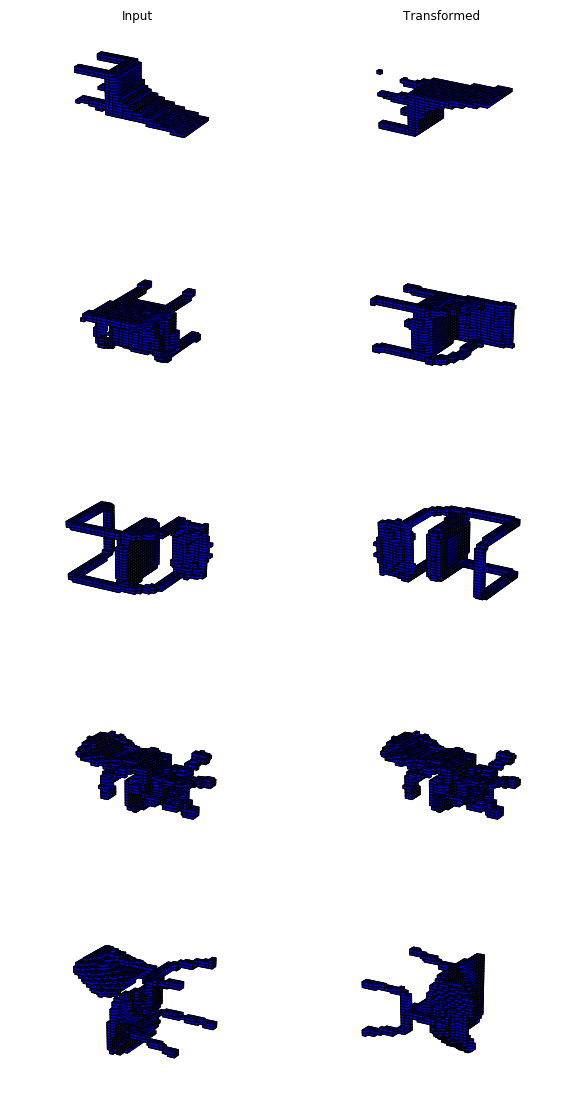

In [69]:
categories = ['chair']
save_path_90aug_90opt = './results/test2_90_aug_opt/avae_modelnet_'+categories[0]+'_90aug_all90_l8'
checkpoint_90opt = torch.load(save_path_90aug_90opt + '/best_ckpt.pth')

trainset = TransformedModelNetVoxels(modelnet_path, transform_type='random_90_rot', categories=categories, 
                                     resolutions=[32], split='train', device=device)
valset = TransformedModelNetVoxels(modelnet_path, transform_type='none', categories=categories, 
                                   resolutions=[32], split='test', device=device)
train_loader = DataLoader(trainset, batch_size=bs)
val_loader = DataLoader(valset, batch_size=2*bs)
val_batch = next(iter(val_loader))

plot_transformed_voxels(val_batch, 
                      affine_params_data=torch.FloatTensor(checkpoint_90opt['data_ap_list']), 
                      affine_params_model=torch.FloatTensor(checkpoint_90opt['model_ap_list']), 
                      nsamples=5,
                      save_path='./plots/'+str(categories[0])+'_rotated.pdf')

data_ap = checkpoint_90opt['data_ap_list']
model_ap = checkpoint_90opt['model_ap_list']
rotation_mats = []
rotation_angles = []
for i in range(data_ap.shape[0]):
    rotation_mats.append(np.matmul(data_ap[i, :,:3], model_ap[i, :,:3]))

rotation_angles = [rotationMatrixToEulerAngles(x) for x in rotation_mats]
str_angles = Counter([''.join(str(e)) for e in rotation_angles])
str_angles = {k: v for k, v in sorted(str_angles.items(), key=lambda item: item[1], reverse=True)}
str_angles

## Estimate Consistency
Are transformed shapes more "consistent"? We can simplify this to saying on average do the shapes occupy a similar volume?
* Compare variance of individual pixels in raw and transformed data

In [90]:
categories = ['sofa']
save_path_90aug_90opt = './results/test2_90_aug_opt/avae_modelnet_'+categories[0]+'_90aug_all90_l8'
checkpoint_90opt = torch.load(save_path_90aug_90opt + '/best_ckpt.pth')
affine_params_data=torch.FloatTensor(checkpoint_90opt['data_ap_list'])
affine_params_model=torch.FloatTensor(checkpoint_90opt['model_ap_list'])

valset = TransformedModelNetVoxels(modelnet_path, transform_type='none', categories=categories, 
                                   resolutions=[32], split='test', device=device)
val_loader = DataLoader(valset, batch_size=25)
# batch = next(iter(val_loader))
# x = batch['data']['32']

converting to voxels to resolution 32: 100%|██████████| 100/100 [00:00<00:00, 31859.51it/s]


In [91]:
x.std(dim=0).mean()

tensor(0.1446, device='cuda:0')

In [111]:
def compare_std_transform(save_path, category):
    checkpoint_90opt = torch.load(save_path)
    affine_params_data=torch.FloatTensor(checkpoint_90opt['data_ap_list'])
    affine_params_model=torch.FloatTensor(checkpoint_90opt['model_ap_list'])
    valset = TransformedModelNetVoxels(modelnet_path, transform_type='none', categories=[category], 
                                       resolutions=[32], split='test', device=device)
    val_loader = DataLoader(valset, batch_size=25)
    
    augmented_x, transformed_x = [], []
    idx = 0
    for batch in val_loader:
        x = batch['data']['32'].to(device).unsqueeze(1)
        aug_x_batch = affine_transform(x, affine_params_data[idx:idx+x.size(0), :, :], padding_mode='zeros')
        augmented_x.append(aug_x_batch)
        transformed_x.append(affine_transform(aug_x_batch, affine_params_model[idx:idx+x.size(0), :, :], padding_mode='zeros'))
        idx += x.size(0)
    augmented_x = torch.cat(augmented_x)
    transformed_x = torch.cat(transformed_x)
    augmented_x_std = augmented_x.std(dim=0).mean()
    transformed_x_std = transformed_x.std(dim=0).mean()
    return augmented_x_std.item(), transformed_x_std.item()


save_path = './results/test2_90_aug_opt/avae_modelnet_'+categories[0]+'_90aug_all90_l8' + '/best_ckpt.pth'

for category in ['desk', 'sofa', 'toilet', 'chair']:
    aug_std, trans_std = compare_std_transform(save_path, category)
    print(f'Object type: {category}, decrease in standard deviation: {100* (1 - trans_std/aug_std):.{3}}%')

converting to voxels to resolution 32: 100%|██████████| 100/100 [00:00<00:00, 29641.72it/s]

Object type: desk, decrease in standard deviation: 6.04%



converting to voxels to resolution 32: 100%|██████████| 100/100 [00:00<00:00, 25862.03it/s]

Object type: sofa, decrease in standard deviation: 10.9%



converting to voxels to resolution 32: 100%|██████████| 100/100 [00:00<00:00, 21849.89it/s]

Object type: toilet, decrease in standard deviation: 1.41%


Object type: chair, decrease in standard deviation: 0.857%


In [ ]:


val_batch = next(iter(val_loader))

plot_transformed_voxels(val_batch, 
                      affine_params_data=torch.FloatTensor(checkpoint_90opt['data_ap_list']), 
                      affine_params_model=torch.FloatTensor(checkpoint_90opt['model_ap_list']), 
                      nsamples=5,
                      save_path='./plots/'+str(categories[0])+'_rotated.pdf')

data_ap = checkpoint_90opt['data_ap_list']
model_ap = checkpoint_90opt['model_ap_list']
rotation_mats = []
rotation_angles = []
for i in range(data_ap.shape[0]):
    rotation_mats.append(np.matmul(data_ap[i, :,:3], model_ap[i, :,:3]))

rotation_angles = [rotationMatrixToEulerAngles(x) for x in rotation_mats]
str_angles = Counter([''.join(str(e)) for e in rotation_angles])
str_angles = {k: v for k, v in sorted(str_angles.items(), key=lambda item: item[1], reverse=True)}
str_angles

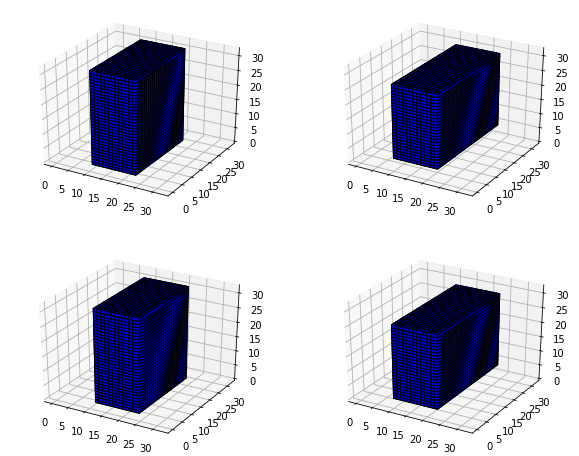

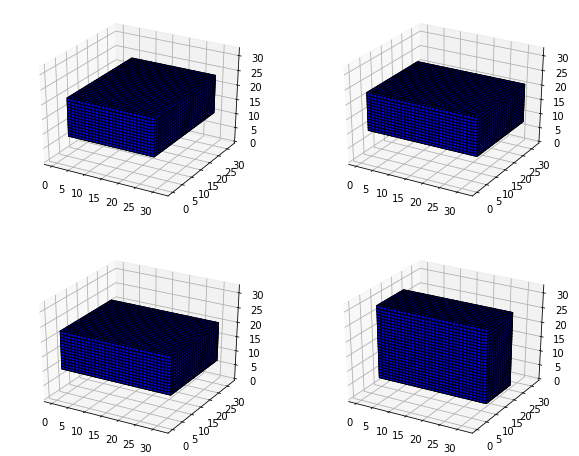

In [147]:
good_rotations = [[0., -0.,  0.],
                 [3.1416, -0.,   -1.5708], 
                 [3.1416, -0.,    3.1416],
                 [3.1416, -0.,    1.5708]]

bad_rotations = [[1.5708, 1.5708, 0.  ],
                 [-3.1416, -1.5708,  0. ], 
                 [-0.,   -1.5708,  0.  ],
                 [ 1.5708, -0.,    1.5708]]

def rot_to_affine(rot_mat):
    affine_mat = torch.zeros(3, 4)
    affine_mat[:, :3] = torch.FloatTensor(rot_mat)
    n_digits = 3
    affine_mat = (affine_mat * 10**n_digits).round() / (10**n_digits)
    return(affine_mat.unsqueeze(0))


good_rotations = [rot_to_affine(eulerAnglesToRotationMatrix(angle)) for angle in good_rotations]
bad_rotations = [rot_to_affine(eulerAnglesToRotationMatrix(angle)) for angle in bad_rotations]


def affine_transform(x, affine_params, padding_mode='zeros'):
    grid = F.affine_grid(affine_params, x.size(), align_corners=False).cuda()
    x = F.grid_sample(x, grid, padding_mode=padding_mode, align_corners=False)
    return x
        
batch = next(iter(val_loader))
x = batch['data']['32'][5, :, :, :].to(device).unsqueeze(0).unsqueeze(0)
show_rotations(x, good_rotations)
show_rotations(x, bad_rotations)

In [148]:
good_rotations

[tensor([[[1., 0., 0., 0.],
          [0., 1., 0., 0.],
          [0., 0., 1., 0.]]]),
 tensor([[[-0., -1.,  0.,  0.],
          [-1.,  0., -0.,  0.],
          [ 0., -0., -1.,  0.]]]),
 tensor([[[-1., -0.,  0.,  0.],
          [-0.,  1., -0.,  0.],
          [ 0., -0., -1.,  0.]]]),
 tensor([[[-0.,  1., -0.,  0.],
          [ 1.,  0., -0.,  0.],
          [ 0., -0., -1.,  0.]]])]

In [78]:
data_ap = checkpoint_noopt['data_ap_list']
model_ap = checkpoint_noopt['model_ap_list']

data_dists = []
model_dists = []
data_model_dists = []
for i in range(rotation_array.shape[0]):
    data_dists.append(np.dot(rotationMatrixToEulerAngles(data_ap[i, :,:]), np.array([1, 1, 1])))
    model_dists.append(np.dot(rotationMatrixToEulerAngles(model_ap[i, :,:]), np.array([1, 1, 1])))
    data_model_dists.append(rotationMatrixToEulerAngles(np.matmul(np.squeeze(data_ap[i, :,:3]), np.squeeze(model_ap[i, :,:3]))))
    
Counter([''.join(str(e)) for e in data_model_dists])

Counter({'[-1.57 -1.57  0.  ]': 4,
         '[ 0.   -0.    1.57]': 4,
         '[ 0. -0.  0.]': 3,
         '[ 1.57 -0.   -1.57]': 5,
         '[ 1.57 -0.    0.  ]': 3,
         '[-1.57 -0.   -1.57]': 3,
         '[1.57 1.57 0.  ]': 6,
         '[-1.57 -0.    3.14]': 2,
         '[ 3.14 -0.    3.14]': 5,
         '[-3.14 -1.57  0.  ]': 2,
         '[ 1.57 -0.    3.14]': 2,
         '[ 3.14 -0.    1.57]': 8,
         '[-0.   -1.57  0.  ]': 5,
         '[-0.    1.57  0.  ]': 3,
         '[ 1.57 -1.57  0.  ]': 6,
         '[ 3.14 -0.    0.  ]': 1,
         '[-1.57  1.57  0.  ]': 4,
         '[-1.57 -0.    1.57]': 4,
         '[-1.57 -0.    0.  ]': 4,
         '[ 1.57 -0.    1.57]': 3,
         '[ 0.   -0.   -1.57]': 7,
         '[-3.14  1.57  0.  ]': 2})

In [46]:
# data_ap = checkpoint_noopt['data_ap_list']
# model_ap = checkpoint_noopt['model_ap_list']

data_ap = checkpoint_90opt['data_ap_list']
model_ap = checkpoint_90opt['model_ap_list']

for i in range(1):
    print('input data:')
    print(data_ap[i, :,:])
    print(rotationMatrixToEulerAngles(data_ap[i, :,:]))
    
    print('model:')
    print(model_ap[i, :,:])
    print(rotationMatrixToEulerAngles(model_ap[i, :,:]))
    print('------------')

input data:
[[ 1.  0.  0.  0.]
 [ 0. -1.  0.  0.]
 [ 0.  0. -1.  0.]]
[ 3.14159265 -0.          0.        ]
model:
[[-1.  0.  0.  0.]
 [ 0. -1.  0.  0.]
 [ 0.  0.  1.  0.]]
[ 0.         -0.          3.14159265]
------------


In [47]:
from collections import Counter
rotation_array = model_ap


data_list = []
for idx in range(rotation_array.shape[0]):
    data_list.append(''.join([''.join(''.join(str(int(e)) for e in rotation_array[idx, :, i].tolist())) for i in range(4)]))
Counter(data_list)

Counter({'-1000-10001000': 2,
         '0010-10100000': 6,
         '1000-1000-1000': 4,
         '00-10-10-100000': 6,
         '0-10-10000-1000': 4,
         '0-10001-100000': 5,
         '00-1-100010000': 3,
         '01010000-1000': 3,
         '00-1010100000': 3,
         '100010001000': 3,
         '01000-1-100000': 3,
         '-100001010000': 2,
         '1000010-10000': 5,
         '001-1000-10000': 3,
         '10000-1010000': 5,
         '-10000-10-10000': 7,
         '010001100000': 7,
         '00-11000-10000': 2,
         '001100010000': 3,
         '-10001000-1000': 2,
         '001010-100000': 1,
         '0-1000-1100000': 3,
         '010-100001000': 3,
         '0-10100001000': 1})

In [ ]:
modelnet_path = './data/ModelNet10'
categories = ['chair']
device = 'cuda:0'

trainset = ModelNetVoxels(modelnet_path, categories=categories, resolutions=[32],
                                         split='train', device=device)
valset = ModelNetVoxels(modelnet_path, categories=categories, resolutions=[32],
                                         split='test', device=device)
trainset.names = trainset.names[:4]
valset.names = valset.names[:256]

print('len(trainset)', len(trainset))
train_loader = DataLoader(trainset, batch_size=2)
val_loader = DataLoader(valset, batch_size=256)

In [ ]:
model = AVAE3d(VAE=VAE(latent_size=8, img_size=32), opt_method='all_90_rot').to(device)


In [3]:
def plot_recon_voxels(batch, model, nsamples=4, voxel_threshold=.5):
    x = batch['data']['32'].to(device)[:nsamples, :, :, :].unsqueeze(1)
    recon_x, mu = model(x)
    recon_x = recon_x > voxel_threshold
    x, recon_x = x.squeeze(), recon_x.squeeze()
    labels = batch['attributes']['category'][:nsamples]
    
    nrows, ncols = nsamples, 2
    fig = plt.figure(figsize=(8, 3*nsamples))
    for idx in range(0, x.size(0), 1):
        label = labels[idx]
        ax = fig.add_subplot(nrows, ncols, 2*idx + 1, projection='3d')
        ax.voxels(x[idx, :, :, :], facecolors='blue', edgecolor='k')
        ax.axis('off')
        ax.set_title(labels[idx])
        
        ax = fig.add_subplot(nrows, ncols, 2*idx + 2, projection='3d')
        ax.voxels(recon_x[idx, :, :, :], facecolors='blue', edgecolor='k')
        ax.axis('off')